In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, jaccard_score, roc_auc_score

import shap

from joblib import dump, load
import catboost as cb
from catboost import CatBoostClassifier

In [31]:
campaign_num = 3476
file_path = f'/Volumes/My Passport/ipinyou/make-ipinyou-data-master/{campaign_num}/test.log.txt'
df = pd.read_csv(file_path, delimiter="\t")
df.head()

,click,weekday,hour,bidid,timestamp,logtype,ipinyouid,useragent,IP,region,...,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag,nclick,nconversation
0,0,4,15,7a538d6d39be17deebc6ef23da2051bd,20130613155706970,1,Vhk71AduPUa8GdE,windows_chrome,124.65.150.*,1,...,0,5,e1af08818a6cd6bbba118bb54a651961,249,107,a5d0bde104fea52ea466c77b37948424,3476,"10052,10133,10110",0,0
1,0,4,15,23bed9ca8f6ed5e4d44e1d0d8703a809,20130613155707268,1,Vh5KPvk8PH16e-L,windows_ie,182.242.186.*,308,...,1,0,f65c8bdb41e9015970bac52baa813239,238,68,9be83422522025c09a44593ecd1af8ca,3476,"13866,10006,10110",0,0
2,0,4,15,2099c814192c711cb9cd2b733a3f6831,20130613155707333,1,Vh1dL3pAOyNOFhL,windows_chrome,218.56.152.*,146,...,0,5,e1af08818a6cd6bbba118bb54a651961,249,5,a5d0bde104fea52ea466c77b37948424,3476,"10083,10063,14273,10077,10052,10006,11944,1004...",0,0
3,0,4,15,ffc0662ec729d2477779c705b821b053,20130613155707552,1,Vh2RCep2D8L8wdR,windows_ie,61.144.48.*,216,...,1,0,e1af08818a6cd6bbba118bb54a651961,238,74,a5d0bde104fea52ea466c77b37948424,3476,"10093,10063,10076,10075,10059,13866,10083,1000...",0,0
4,0,4,15,72be2159da8ffb09bc995a2ab1ea5483,20130613155707823,1,Vh5KPvk8DILyJfL,windows_ie,122.67.24.*,40,...,1,0,c938195f9e404b4f38c7e71bf50263e5,238,250,a3becb967c015e9acb5e72f22b100ef8,3476,"10063,13800,10133,10116",0,0


In [32]:
df["datetime"] = pd.to_datetime(df["timestamp"], format="%Y%m%d%H%M%S%f")

In [33]:
df.columns.tolist()

['click',
 'weekday',
 'hour',
 'bidid',
 'timestamp',
 'logtype',
 'ipinyouid',
 'useragent',
 'IP',
 'region',
 'city',
 'adexchange',
 'domain',
 'url',
 'urlid',
 'slotid',
 'slotwidth',
 'slotheight',
 'slotvisibility',
 'slotformat',
 'slotprice',
 'creative',
 'bidprice',
 'payprice',
 'keypage',
 'advertiser',
 'usertag',
 'nclick',
 'nconversation',
 'datetime']

In [34]:
df.set_index("datetime", inplace=True)
df_5min = df.resample('5T').agg({
    "weekday":"mean",
    "hour":"mean",
    "bidid":"count",
    "payprice":"mean",
    "nclick":"sum"}).reset_index()
df_5min.head()

,datetime,weekday,hour,bidid,payprice,nclick
0,2013-06-13 15:55:00,4.0,15.0,6040,85.119040,3
1,2013-06-13 16:00:00,4.0,16.0,6494,92.877425,4
2,2013-06-13 16:05:00,4.0,16.0,7117,92.551637,11
3,2013-06-13 16:10:00,4.0,16.0,7852,97.110036,4
4,2013-06-13 16:15:00,4.0,16.0,7611,101.623834,1


In [35]:
df_5min = df_5min.rename(columns={"nclick":"click"})
df_5min["ctr"] = (df_5min["click"]/df_5min["bidid"])*100
df_5min["ctr"] = df_5min["ctr"].fillna(0)
df_5min.rename(columns={"bidid":"bid count"}, inplace=True)
df_5min.head()

,datetime,weekday,hour,bid count,payprice,click,ctr
0,2013-06-13 15:55:00,4.0,15.0,6040,85.119040,3,0.049669
1,2013-06-13 16:00:00,4.0,16.0,6494,92.877425,4,0.061595
2,2013-06-13 16:05:00,4.0,16.0,7117,92.551637,11,0.154560
3,2013-06-13 16:10:00,4.0,16.0,7852,97.110036,4,0.050942
4,2013-06-13 16:15:00,4.0,16.0,7611,101.623834,1,0.013139


In [36]:
df_5min["bid count (t-1)"], df_5min["payprice (t-1)"], df_5min["click (t-1)"], df_5min["ctr (t-1)"] = df_5min["bid count"].shift(1), df_5min["payprice"].shift(1), df_5min["click"].shift(1), df_5min["ctr"].shift(1)
df_5min.head()

,datetime,weekday,hour,bid count,payprice,click,ctr,bid count (t-1),payprice (t-1),click (t-1),ctr (t-1)
0,2013-06-13 15:55:00,4.0,15.0,6040,85.119040,3,0.049669,NaN,NaN,NaN,NaN
1,2013-06-13 16:00:00,4.0,16.0,6494,92.877425,4,0.061595,6040.0,85.119040,3.0,0.049669
2,2013-06-13 16:05:00,4.0,16.0,7117,92.551637,11,0.154560,6494.0,92.877425,4.0,0.061595
3,2013-06-13 16:10:00,4.0,16.0,7852,97.110036,4,0.050942,7117.0,92.551637,11.0,0.154560
4,2013-06-13 16:15:00,4.0,16.0,7611,101.623834,1,0.013139,7852.0,97.110036,4.0,0.050942


In [37]:
save_path = f'/Users/sujitkhanna/Desktop/Courses/capstone/code base/rtb_exploration/campaign/test/{campaign_num}/train_5min_agg.csv'
df_5min.iloc[1:].to_csv(save_path)

# CTR prediction regression model

In [100]:
pred_df = pd.read_csv(save_path)
pred_df.drop(columns=["Unnamed: 0"], inplace=True)
# pred_df.dropna(inplace=True)
pred_df.

(950, 11)

In [105]:
pred_df.isnull().sum()

datetime             0
weekday            492
hour               492
bid count            0
payprice           492
click                0
ctr                  0
bid count (t-1)      0
payprice (t-1)     492
click (t-1)          0
ctr (t-1)            0
dtype: int64

## Perform time-series analysis

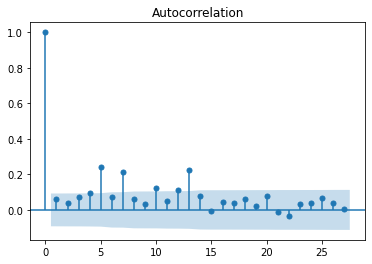

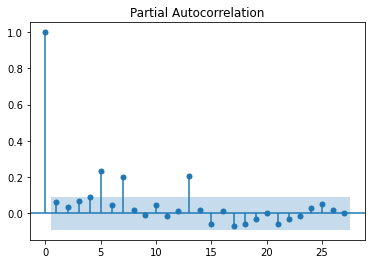

In [90]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
ts_df = pred_df['ctr']
plot_acf(ts_df.iloc[:1000])
plt.show()
plot_pacf(ts_df.iloc[:1000])
plt.show()

## Perform rolling block predictions

In [91]:
# pred_df = sklearn.utils.shuffle(pred_df)
rolling_window = 500
test_size = 100
#creating data blocks
data_list = []
for i in range(rolling_window, pred_df.shape[0], test_size):
    data_list.append(pred_df.iloc[i-rolling_window:i, :])


In [92]:
len(data_list)

0

In [73]:
# ip_features = ["weekday", "hour", "bid count (t-1)","payprice (t-1)","click (t-1)","ctr (t-1)"]
# op_features = ["ctr"]
# test_split = 0.25
# X_train, X_test, y_train, y_test = train_test_split(pred_df[ip_features], pred_df[op_features], test_size=test_split, random_state=42)
# X_train.index, X_test.index, y_train.index, y_test.index = list(range(X_train.shape[0])), list(range(X_test.shape[0])), \
#                                                            list(range(y_train.shape[0])), list(range(y_test.shape[0]))

In [74]:
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor


ip_features = ["hour", "bid count (t-1)", "click (t-1)", "payprice (t-1)"]
# ip_features = ["weekday", "hour", "bid count (t-1)","payprice (t-1)","click (t-1)","ctr (t-1)"]
op_features = ["ctr"]
preds_list, true_list, datetime = [], [], []
for i,pred_data in enumerate(data_list):
#     pred_data = sklearn.utils.shuffle(pred_data)
    pred_data.index = list(range(pred_data.shape[0]))
    X_train, y_train = pred_data[ip_features].iloc[:rolling_window-test_size], pred_data[op_features].iloc[:rolling_window-test_size]
    X_test, y_test = pred_data[ip_features].iloc[rolling_window-test_size:], pred_data[op_features].iloc[rolling_window-test_size:]
    X_datetime = pred_data["datetime"].iloc[rolling_window-test_size:]
#     model = RandomForestRegressor(max_depth=2, random_state=0)
    model = CatBoostRegressor(iterations=10000,
                              learning_rate=0.02)

    # Fit model
#     model.fit(X_train, y_train)
    # # Get predictions
    model.fit(X_train.values, y_train.values, verbose=False)
    preds = model.predict(X_test.values)
    preds_list.append(preds)
    true_list.append(y_test.values)
    datetime.append(X_datetime.values)
    print(f"MAE for rolling window {i} is: {mean_absolute_error(y_test.values,preds)}")
    

MAE for rolling window 0 is: 0.07513561504480237


In [75]:
preds_ary = np.asarray(preds_list).astype(float)
preds_ary = preds_ary.flatten()
y_test_ary = np.asarray(true_list).astype(float)
y_test_ary = y_test_ary.flatten()
y_test_date = np.asarray(datetime).astype(str)
y_test_date = y_test_date.flatten()
y_test_ary[np.argmax(y_test_ary)] = 0
preds_ary[np.where(preds_ary<0)] = 0
print(f"MAE for the entire campaign is: {mean_absolute_error(preds_ary,y_test_ary)}")

MAE for the entire campaign is: 0.06905516412954274


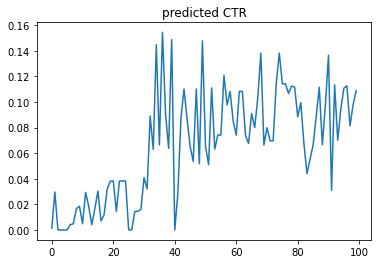

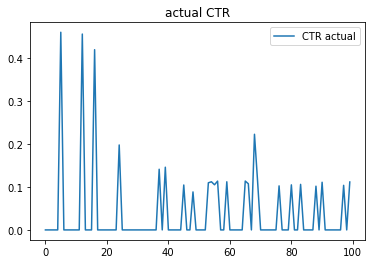

In [76]:
fig = plt.figure()
ax = plt.axes()
plt.plot(list(range(preds_ary.shape[0])),preds_ary , label='CTR pred')
plt.title("predicted CTR")
plt.show()
plt.plot(list(range(y_test_ary.shape[0])),y_test_ary , label='CTR actual')
plt.title("actual CTR")
plt.legend()
plt.show()

## Format of the final dataset
### fields: datetime, campaign_num, total_clicks(t-1), ctr(t-1), ctr_pred(t), time_of_day(t), avg_bid_price(t-1), avg_bid_price(t), ctr(t)
### HDFSTore Tutorials [https://riptutorial.com/pandas/example/9812/using-hdfstore] [https://dzone.com/articles/quick-hdf5-pandas] [https://stackoverflow.com/questions/14591855/pandas-hdfstore-how-to-reopen]


In [77]:
ctr_pred_df = pd.DataFrame({"datetime":y_test_date, "ctr_pred":preds_ary})
ctr_pred_df["datetime"] = pd.to_datetime(ctr_pred_df["datetime"])
ctr_pred_df.head()

,datetime,ctr_pred
0,2013-10-23 06:35:00,0.001471
1,2013-10-23 06:40:00,0.029596
2,2013-10-23 06:45:00,0.000000
3,2013-10-23 06:50:00,0.000000
4,2013-10-23 06:55:00,0.000000


In [78]:
final_df = pd.merge(ctr_pred_df, df_5min, how="left", on="datetime")
final_df["campaign"] = campaign_num
final_df.head()

,datetime,ctr_pred,weekday,hour,bid count,payprice,click,ctr,bid count (t-1),payprice (t-1),click (t-1),ctr (t-1),campaign
0,2013-10-23 06:35:00,0.001471,3.0,6.0,190,95.831579,0,0.000000,183.0,102.469945,0.0,0.0,2821
1,2013-10-23 06:40:00,0.029596,3.0,6.0,232,99.668103,0,0.000000,190.0,95.831579,0.0,0.0,2821
2,2013-10-23 06:45:00,0.000000,3.0,6.0,209,99.497608,0,0.000000,232.0,99.668103,0.0,0.0,2821
3,2013-10-23 06:50:00,0.000000,3.0,6.0,203,106.955665,0,0.000000,209.0,99.497608,0.0,0.0,2821
4,2013-10-23 06:55:00,0.000000,3.0,6.0,187,104.133690,1,0.534759,203.0,106.955665,0.0,0.0,2821


In [79]:
final_df = final_df.rename(columns={"hour":"tod", "click (t-1)":"tc_prev", "ctr (t-1)":"ctr_prev",
                                    "bid count (t-1)":"total_bids_prev", "payprice (t-1)":"avg_bid_price_prev",
                                    "payprice":"cur_avg_bid_price", "bid count":"total_bids_cur"})
final_df["episode_key"] = final_df["campaign"].astype(str) + '_' + final_df["weekday"].astype(str)
final_df.head()

,datetime,ctr_pred,weekday,tod,total_bids_cur,cur_avg_bid_price,click,ctr,total_bids_prev,avg_bid_price_prev,tc_prev,ctr_prev,campaign,episode_key
0,2013-10-23 06:35:00,0.001471,3.0,6.0,190,95.831579,0,0.000000,183.0,102.469945,0.0,0.0,2821,2821_3.0
1,2013-10-23 06:40:00,0.029596,3.0,6.0,232,99.668103,0,0.000000,190.0,95.831579,0.0,0.0,2821,2821_3.0
2,2013-10-23 06:45:00,0.000000,3.0,6.0,209,99.497608,0,0.000000,232.0,99.668103,0.0,0.0,2821,2821_3.0
3,2013-10-23 06:50:00,0.000000,3.0,6.0,203,106.955665,0,0.000000,209.0,99.497608,0.0,0.0,2821,2821_3.0
4,2013-10-23 06:55:00,0.000000,3.0,6.0,187,104.133690,1,0.534759,203.0,106.955665,0.0,0.0,2821,2821_3.0


In [80]:
store_loc = "./data/rtb_store.h5"
with pd.HDFStore(store_loc,  mode='w') as store:
    store.put(key=f'df_{campaign_num}', value=final_df, data_columns= final_df.columns, format='table')


In [21]:
store_loc = "./data/rtb_1458_hft_store.h5"
with pd.HDFStore(store_loc,  mode='w') as store:
    store.put(key='df_1458', value=df, data_columns= df.columns, format='table')


KeyboardInterrupt: 

## Train High Frequency Cick Preidction model

In [ ]:
init_data = data_list[0]
file_path = "/Users/sujitkhanna/Desktop/Courses/capstone/code base/rtb_exploration/campaign/1458/train.log.txt"
ip_features = ["weekday", "hour", "region", "slotwidth", "slotheight", "slotvisibility", "slotformat", "slotprice", "useragent"]
op_feature = ["click"]
train_size = 0.8

In [ ]:
def gen_data(file_path, in_features, op_features, train_size, date_range_tuple):
    df = pd.read_csv(file_path, delimiter="\t")
    df["datetime"] = pd.to_datetime(df["timestamp"], format="%Y%m%d%H%M%S%f")
    df = df.loc[(df["datetime"]>=date_range_tuple[0]) & (df["datetime"]<=date_range_tuple[1])]
    df["useragent"] = pd.factorize(df['useragent'])[0] + 1
    df["slotarea"] = df["slotwidth"]*df["slotheight"]
    in_features.remove("slotwidth")
    in_features.remove("slotheight")
    df_short = df[in_features + ["slotarea"] + op_features]
    X_train, X_test, y_train, y_test = train_test_split(df_short[in_features], df_short[op_feature[0]], test_size=1-train_size, random_state=42)
    X_train.index, X_test.index, y_train.index, y_test.index = list(range(X_train.shape[0])), list(range(X_test.shape[0])), \
                                                               list(range(y_train.shape[0])), list(range(y_test.shape[0]))
    return X_train, X_test, y_train, y_test

def balance_classes(bal_type, df):
    df_majority = df[df["click"]==0]
    df_minority = df[df["click"] == 1]
    if bal_type=="upsample":
        df_upsample = resample(df_minority, replace=True, n_samples=df_majority.shape[0], random_state=1001)
        df_balanced = pd.concat([df_majority, df_upsample])
    elif bal_type=="downsample":
        df_downsample = resample(df_majority, replace=False, n_samples=df_minority.shape[0], random_state=1001)
        df_balanced = pd.concat([df_minority, df_downsample])
    df_balanced = sklearn.utils.shuffle(df_balanced)
    df_balanced.index = list(range(df_balanced.shape[0]))
    return df_balanced

def train_classifier(classifier_name, train_x, train_y, balance_type=None, save_path="./saved_models/ctr_1428"):
    concat_df = pd.concat([train_x, train_y], axis=1)
    if balance_type is not None:
        balanced_df = balance_classes(balance_type, concat_df)
        train_x_df, train_y_df = balanced_df[train_x.columns.tolist()], balanced_df[train_y.to_frame().columns.tolist()]
    else:
        train_x_df, train_y_df = train_x, train_y

    if classifier_name=="RF":
        clf = RandomForestClassifier(criterion='entropy', max_features=1,
                                     class_weight='balanced')

        clf = BaggingClassifier(base_estimator=clf, n_estimators=20, max_features=1.0,
                                max_samples=1, oob_score=True, n_jobs=1)

        clf.fit(X=train_x_df, y=train_y_df)
        train_preds_y = clf.predict(train_x_df)
        train_preds_proba_y = clf.predict_proba(train_x_df)
        disp = plot_confusion_matrix(clf, train_x_df, train_y_df, cmap=plt.cm.Blues)
        disp.ax_.set_title("COnfusion matrix")
        print(disp.confusion_matrix)
        plt.show()
        print(f"Accuracy on train set is:{accuracy_score(train_y_df,train_preds_y)} ")
        dump(clf, f'{save_path}.joblib')

    elif classifier_name=="catboost":
        # dataset = cb.Pool(train_x_df, train_y_df)
        model = CatBoostClassifier(
            iterations=5000,
            learning_rate=0.02,
            loss_function='CrossEntropy')
        model.fit(train_x_df, train_y_df, verbose=False, plot=True)
        plt.show()
        predict_probs = model.predict_proba(data=train_x_df)
        predict_vals = model.predict(data=train_x_df)
        
        disp = plot_confusion_matrix(model, train_x_df, train_y_df, cmap=plt.cm.Blues)
        disp.ax_.set_title("Confusion matrix")
        print(disp.confusion_matrix)
        plt.show()

        class_report = classification_report(train_y_df, predict_vals)
        print()
        print()
        print(class_report)
        
#         print(f"accuracy is {np.mean(train_y_df.values==predict_vals)}")
        return predict_probs, predict_vals, model, train_x_df, train_y_df
    else:
        pass

In [ ]:
init_data["datetime"] = pd.to_datetime(init_data["datetime"], format="%Y-%m-%d %H:%M:%S")

In [ ]:
date_tuple = (init_data["datetime"].iloc[0], init_data["datetime"].iloc[-1])
date_tuple

In [ ]:
train_x, test_x,train_y, test_y = gen_data(file_path, ip_features, op_feature, train_size, date_tuple)

In [ ]:
predict_probs, predict_vals, model, trunc_train_x, trunc_train_y = train_classifier("catboost",train_x, train_y, balance_type="downsample")

In [ ]:
save_model_path = "./saved_models/hft_ctr_catboost"
model.save_model(save_model_path)
from_file = CatBoostClassifier()
from_file.load_model(save_model_path)

[[98442 77538]
 [   47    70]]


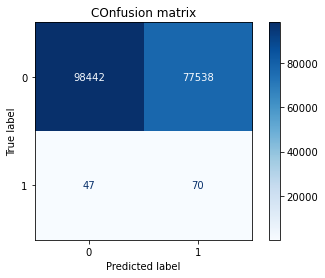





              precision    recall  f1-score   support

           0       1.00      0.56      0.72    175980
           1       0.00      0.60      0.00       117

    accuracy                           0.56    176097
   macro avg       0.50      0.58      0.36    176097
weighted avg       1.00      0.56      0.72    176097



In [55]:
test_preds = from_file.predict(test_x)
# confusion_mat = confusion_matrix(test_y, test_preds)
class_report = classification_report(test_y, test_preds)


disp = plot_confusion_matrix(from_file, test_x, test_y, cmap=plt.cm.Blues)
disp.ax_.set_title("COnfusion matrix")
print(disp.confusion_matrix)
plt.show()

print()
print()
# print("confusion Matrix")
# print(confusion_mat)
print()
print()
print(class_report)